# Q1

Suppose that each of two investments has a 0.9% chance of a loss of $10 million and a 99.1%
chance of a loss of $1 million. The investments are independent of each other.

(a) What is the VaR for one of the investments when the confidence level is 99%?

(b) What is the expected shortfall for one of the investments when the confidence level is 99%?

(c) What is the VaR for a portfolio consisting of the two investments when the confidence  level
is 99%?

(d) What is the expected shortfall for a portfolio consisting of the two investments when the
confidence level is 99%?

(e) Show that in this example VaR does not satisfy the subadditivity condition whereas expected shortfall does.

# Q2

Historical Data (Raw)
           Date  NASDAQ Close
1496   6-Mar-06      2,286.03
1497   7-Mar-06      2,268.38
1498   8-Mar-06      2,267.46
1499   9-Mar-06      2,249.72
1500  10-Mar-06      2,262.04


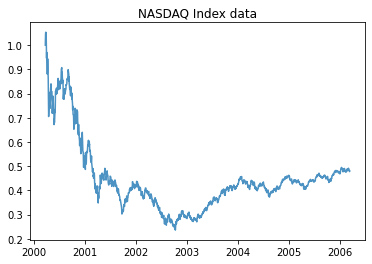

Simulated Data
   Scenario  NASDAQ Close  Portfolio Value  Loss
0         1      2,335.53            10.32 -0.32
1         2      2,297.31            10.16 -0.16
2         3      2,272.30            10.05 -0.05
3         4      2,260.00             9.99  0.01
4         5      2,205.17             9.75  0.25
Total number of scenarios:  1500


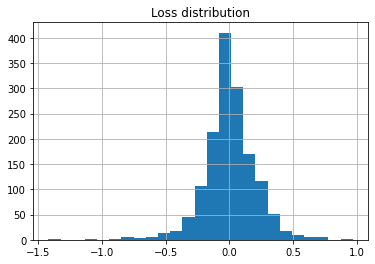

In [54]:
# Pre-processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
# pd.options.display.float_format = '{:,.2f}'.format

# Historical data of the four indices adjusted to USD
df = pd.read_csv('ps4_data.csv')
print('Historical Data (Raw)')
print(df.tail())

# Plot Index data
dates = pd.to_datetime(df.Date)
plt.plot(dates, df['NASDAQ Close']/df.iat[0,1], label = 'DJIA (normalized)', alpha = 0.8)
plt.title('NASDAQ Index data')
plt.show()

# Position
position = 10
lastPrice = df.iat[-1,1]

# construct the simulated scenarios
df_simulation = pd.DataFrame(lastPrice * (df.iloc[1:, 1]) / (df.shift(periods=1).iloc[1:, 1]))
df_simulation['Portfolio Value'] = df_simulation['NASDAQ Close'] / lastPrice * position
df_simulation['Loss'] = position - df_simulation['Portfolio Value'] 
df_simulation.reset_index(inplace = True)
df_simulation.rename(columns={"index": "Scenario"}, inplace = True)

print('Simulated Data')
print(df_simulation.head(5))

# Total number of scenarios
n = len(df_simulation)
print('Total number of scenarios: ', n)

# histogram of portfolio losses
df_simulation.Loss.hist(bins = 25)
plt.title('Loss distribution')
plt.show()

# 2a

In [55]:
# Historical Simulation Approach
# Defining the confidence level alpha 
alpha = 0.99
n = len(df_simulation)
# Ranked Loss
df_loss = df_simulation[['Scenario','Loss']].sort_values(by = 'Loss', ascending = False)
print('Loss distribution: from the worst to the best')
print(df_loss.head(5))

# Method 1: VaR and ES calculation using Percentile Function
losses = df_simulation.Loss.values

VaR  = np.percentile(losses, alpha * 100, method = 'higher') 
ES = np.mean(losses [losses >= VaR])

print('---')
print('VaR (pctl): ', VaR)
print('ES (pctl)', ES)

# Method 2: VaR and ES calculation from ranked Loss
losses_sorted = df_loss.Loss.values

Critial_index = 4 ## What is critical index for?
VaR  = losses_sorted[Critial_index]
ES = np.mean( losses_sorted[0: Critial_index + 1] )
print('---')
print('VaR (ranked loss): ', VaR)
print('ES (ranked loss)', ES)

Loss distribution: from the worst to the best
     Scenario  Loss
17         18  0.97
8           9  0.76
197       198  0.72
190       191  0.71
15         16  0.71
---
VaR (pctl):  0.5389382836766909
ES (pctl) 0.6566113297444226
---
VaR (ranked loss):  0.7058112872605342
ES (ranked loss) 0.7743490122508927


# 2b

In [56]:
# Exponential Weighting scheme
Lambda = 0.995
n = len(df_simulation)
df_loss['Weight'] = np.power(Lambda, n - df_loss['Scenario']) * (1- Lambda) / (1- np.power(Lambda, n))
df_loss['Cum Weight'] = np.cumsum(df_loss.Weight)
print(df_loss.head(5))

# VaR and ES calculation

weights = df_loss['Weight'].values
cum_weights = df_loss['Cum Weight'].values
losses_sorted = df_loss.Loss.values

Critial_index = np.where(cum_weights >= 1 - alpha, np.arange(n) , np.inf).argmin()
VaR  = df_loss.Loss.iloc[Critial_index]

w_for_ES = weights[0:Critial_index].tolist() + [1 - alpha - cum_weights[Critial_index-1]]
ES = np.sum( losses_sorted[0: Critial_index + 1] * w_for_ES )/ (1-alpha)

# print('Weight for ES: ', w_for_ES)

print('VaR: ', VaR)
print('ES ', ES)

     Scenario  Loss  Weight  Cum Weight
17         18  0.97    0.00        0.00
8           9  0.76    0.00        0.00
197       198  0.72    0.00        0.00
190       191  0.71    0.00        0.00
15         16  0.71    0.00        0.00
VaR:  0.22940148030210672
ES  0.2712884275794882


# 2c

In [57]:
# Daily net returns assumed normally distributed with mean zero
from scipy.stats import norm

sigma = losses_sorted.std() 
VaR = 0 + sigma * norm.ppf(alpha)
ES = 0 + sigma * norm.pdf(norm.ppf(alpha))/(1-alpha)

print('VaR: ',  VaR)
print('ES ', ES)

VaR:  0.46796727696068374
ES  0.5361335057106865


# 2d

Reason for differences: 
1) Simulation method is based on past performance alone, high degree of variance between each day
2) Exponential weighting scheme places less weight on historical values, lower variance and likely to follow trend of more recent days
3) Direct standard deviation : not sure exactly why this is different from pctl

# Questions to clarify


a) Monotonicity: What case will this not hold?

b) Translation Invariance: x is a fixed value, that reduces risk by x amount, taking a loan to cover the risk, what if x is negative

c) Positive Homogeneity: Doesnt this directly contradict diversification based on its loose terms